In [1]:
import argparse
import os
import sys

import dolfinx
import matplotlib.pyplot as plt
import numpy as np
import ufl

from dolfinx import fem, mesh

from dolfinx.cpp.mesh import cell_num_entities

from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
from dolfinx.io import gmshio, VTXWriter
from mpi4py import MPI
from petsc4py import PETSc
from ufl import div, dot, grad, inner

import commons, solvers, utils

LX = 75e-6
Wa_p = 1e3
kappa_elec = 0.1  # S/m
faraday_const = 96485
R = 8.3145
T = 298
i0_p = kappa_elec * R * T / (faraday_const * Wa_p * LX)
kr = 1
voltage = 1

In [2]:
def compute_cell_boundary_facets(domain, ct, marker):
    """Compute the integration entities for integrals around the
    boundaries of all cells in domain.

    Parameters:
        domain: The mesh.
        ct: cell tags
        marker: physical group label

    Returns:
        Facets to integrate over, identified by ``(cell, local facet
        index)`` pairs.
    """
    tdim = domain.topology.dim
    fdim = tdim - 1
    n_f = cell_num_entities(domain.topology.cell_type, fdim)

    cells_1 = ct.find(marker)
    perm = np.argsort(cells_1)
    n_c = cells_1.shape[0]

    return np.vstack((np.repeat(cells_1[perm], n_f), np.tile(np.arange(n_f), n_c))).T#.flatten()

In [3]:
def compute_interface_cell_boundary_facets(domain, ct, ft, cell_marker, facet_marker):
    """
    Compute integration entities for integrals around the boundaries of cells at the
    location of prescribed flux expression

    domain: the mesh
    ct: cell tags
    ft: facet tags
    cell_marker: marker for subdomain
    facet_marker: marker for interface
    """
    f_to_c = domain.topology.connectivity(fdim, tdim)
    c_to_f = domain.topology.connectivity(tdim, fdim)
    ft_imap = domain.topology.index_map(fdim)
    num_facets = ft_imap.size_local + ft_imap.num_ghosts
    interface_facets = ft.find(facet_marker)

    int_facet_domain = []
    lcells = []
    for f in interface_facets:
        if f >= ft_imap.size_local or len(f_to_c.links(f)) != 2:
            continue
        c_0, c_1 = f_to_c.links(f)[0], f_to_c.links(f)[1]
        subdomain_0, subdomain_1 = ct.values[[c_0, c_1]]
        local_f_0 = np.where(c_to_f.links(c_0) == f)[0][0]
        local_f_1 = np.where(c_to_f.links(c_1) == f)[0][0]
        if subdomain_0 == cell_marker:
            # lcells.append(c_0)
            int_facet_domain.append([c_0, local_f_0])
            continue
        elif subdomain_1 == cell_marker:
            # lcells.append(c_1)
            int_facet_domain.append([c_1, local_f_1])
            continue
    # lcells = sorted(list(set(lcells)))

    # for cid in lcells:
    #     int_facet_domain.extend([[cid, idx] for idx in range(3)])

    return int_facet_domain

In [4]:
def delete_numpy_rows(in_arr, to_delete):
    out_arr = in_arr
    for row in to_delete:
        idx = np.where(np.all(out_arr == row, axis=1))[0][0]
        out_arr = np.delete(out_arr, idx, axis=0)

    return out_arr

In [5]:
markers = commons.Markers()
mesh_folder = "output/reaction_distribution/75-40-0/unrefined/1.0"
comm = MPI.COMM_WORLD
rank = comm.rank
dtype = PETSc.ScalarType
workdir = os.path.join(mesh_folder, "hdg")
utils.make_dir_if_missing(workdir)
output_meshfile = os.path.join(mesh_folder, 'mesh.msh')
lines_h5file = os.path.join(mesh_folder, 'lines.h5')
potential_resultsfile = os.path.join(workdir, "potential.bp")
u_resultsfile = os.path.join(workdir, "u.bp")
ubar_resultsfile = os.path.join(workdir, "ubar.bp")
concentration_resultsfile = os.path.join(workdir, "concentration.bp")
current_resultsfile = os.path.join(workdir, "current.bp")
simulation_metafile = os.path.join(workdir, "simulation.json")

In [6]:
partitioner = mesh.create_cell_partitioner(mesh.GhostMode.shared_facet)
domain, ct, ft = gmshio.read_from_msh(output_meshfile, comm, partitioner=partitioner)
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(tdim, fdim)
domain.topology.create_connectivity(tdim, tdim)
domain.topology.create_connectivity(fdim, fdim)

# tag internal facets as 0
ft_imap = domain.topology.index_map(fdim)
num_facets = ft_imap.size_local + ft_imap.num_ghosts
indices = np.arange(0, num_facets)
values = np.zeros(indices.shape, dtype=np.intc)
values[ft.indices] = ft.values
ft = mesh.meshtags(domain, fdim, indices, values)
ct = mesh.meshtags(domain, tdim, ct.indices, ct.values)

Info    : Reading 'output/reaction_distribution/75-40-0/unrefined/1.0/mesh.msh'...
Info    : 35 entities
Info    : 3606 nodes
Info    : 7330 elements
Info    : Done reading 'output/reaction_distribution/75-40-0/unrefined/1.0/mesh.msh'


In [7]:
phase1 = markers.electrolyte
phase2 = markers.positive_am
phase1_facets = compute_cell_boundary_facets(domain, ct, phase1)
phase1_interface_facets = compute_interface_cell_boundary_facets(domain, ct, ft, markers.electrolyte, markers.electrolyte_v_positive_am)
phase2_facets = compute_cell_boundary_facets(domain, ct, phase2)
phase2_interface_facets = compute_interface_cell_boundary_facets(domain, ct, ft, markers.positive_am, markers.electrolyte_v_positive_am)

In [8]:
out_arr1 = delete_numpy_rows(phase1_facets, phase1_interface_facets)
out_arr2 = delete_numpy_rows(phase2_facets, phase2_interface_facets)
phase_1_facets = out_arr1.flatten()
phase_1_interface_facets = np.array(phase1_interface_facets).flatten()
phase_2_facets = out_arr2.flatten()
phase_2_interface_facets = np.array(phase2_interface_facets).flatten()

In [9]:
# # Create the sub-mesh
facet_mesh, facet_mesh_to_mesh, _, _ = mesh.create_submesh(domain, fdim, ft.indices)
mesh_to_facet_mesh = np.full(num_facets, -1)
mesh_to_facet_mesh[facet_mesh_to_mesh] = np.arange(len(facet_mesh_to_mesh))
entity_maps = {facet_mesh: mesh_to_facet_mesh}

In [10]:
# Create the sub-mesh
# non_interface = np.array(sorted(set(ft.indices).difference(set(ft.find(markers.electrolyte_v_positive_am)))))
# facet_mesh, facet_mesh_to_mesh, _, _ = mesh.create_submesh(domain, fdim, non_interface)
# mesh_to_facet_mesh = np.full(num_facets, -1)
# mesh_to_facet_mesh[facet_mesh_to_mesh] = np.arange(len(facet_mesh_to_mesh))
# entity_maps = {facet_mesh: [v0 for v0 in mesh_to_facet_mesh if v0 != -1]}

In [11]:
# Create the sub-mesh
# interface_mesh, interface_mesh_to_mesh, _, _ = mesh.create_submesh(domain, fdim, ft.find(markers.electrolyte_v_positive_am))
# mesh_to_interface_mesh = np.full(num_facets, -1)
# mesh_to_interface_mesh[interface_mesh_to_mesh] = np.arange(len(interface_mesh_to_mesh))
# entity_maps[interface_mesh] = [v0 for v0 in mesh_to_interface_mesh if v0 != -1]

In [12]:
# properties
Q = fem.functionspace(domain, ('DG', 0))
kappa = fem.Function(Q)
cells_elec = ct.find(markers.electrolyte)
kappa.x.array[cells_elec] = np.full_like(cells_elec, kappa_elec, dtype=dtype)

kappa_pos_am = kappa_elec / kr
cells_pos_am = ct.find(markers.positive_am)
kappa.x.array[cells_pos_am] = np.full_like(cells_pos_am, kappa_pos_am, dtype=dtype)

# function spaces
k = 3
V = fem.functionspace(domain, ("Discontinuous Lagrange", k))
W = fem.functionspace(domain, ("Discontinuous Lagrange", k))
Vbar = fem.functionspace(facet_mesh, ("Discontinuous Lagrange", k))

# Cell space
u, v = fem.Function(V), ufl.TestFunction(V)

# Facet space
ubar, vbar = fem.Function(Vbar), ufl.TestFunction(Vbar)

# Define integration measures
# Cell
dx_c = ufl.Measure("dx", domain=domain, subdomain_data=ct)
# Cell boundaries
# We need to define an integration measure to integrate around the
# boundary of each cell.

ds_c = ufl.Measure("ds", subdomain_data=[(phase1, phase_1_facets), (phase2, phase_2_facets), (29, phase_1_interface_facets), (30, phase_2_interface_facets)], domain=domain)
# ds_c = ufl.Measure("ds", subdomain_data=[(phase1, phase_1_facets), (phase2, phase_2_facets)], domain=domain)
dS = ufl.Measure("dS", domain=domain, subdomain_data=ft)
ds = ufl.Measure("ds", domain=domain, subdomain_data=ft)
# Create a cell integral measure over the facet mesh
dx_f = ufl.Measure("dx", domain=facet_mesh, subdomain_data=ft)

In [13]:
h = ufl.CellDiameter(domain)
n = ufl.FacetNormal(domain)
gamma = 16.0 * k**2 / h  # Scaled penalty parameter

x = ufl.SpatialCoordinate(domain)

In [14]:
left_boundary = ft.find(markers.left)
right_boundary = ft.find(markers.right)

# Since the boundary condition is enforced in the facet space, we must
# use the mesh_to_facet_mesh map to get the corresponding facets in
# facet_mesh
left_facet_mesh_boundary_facets = mesh_to_facet_mesh[left_boundary]
right_facet_mesh_boundary_facets = mesh_to_facet_mesh[right_boundary]
# Get the dofs and apply the bondary condition
facet_mesh.topology.create_connectivity(fdim, fdim)
left_dofs = fem.locate_dofs_topological(Vbar, fdim, left_facet_mesh_boundary_facets)
right_dofs = fem.locate_dofs_topological(Vbar, fdim, right_facet_mesh_boundary_facets)
left_bc = fem.dirichletbc(dtype(0.0), left_dofs, Vbar)
right_bc = fem.dirichletbc(dtype(voltage), right_dofs, Vbar)
bcs = [left_bc, right_bc]

In [15]:
i_n = -kappa * inner(grad(u), n)
jump_u = R * T / (i0_p * faraday_const) * i_n

The first equation is given by
\begin{equation}
F_0 = \sum_{K\in\mathcal{T}_h}\int_{K}\kappa \nabla u \cdot \nabla v\mathrm{dx} - \sum_{K\in\mathcal{T}_h}\int_{\partial K} \kappa \nabla v \cdot \pmb{n} (u - \bar{u}) \mathrm{ds} + \sum_{K\in\mathcal{T}_h}\int_{\partial K} \kappa \nabla u \cdot \pmb{n} v \mathrm{ds} + \sum_{K\in\mathcal{T}_h}\int_{\partial K} \gamma \kappa (u - \bar{u}) v \mathrm{ds}
\end{equation}
The second equation is given by
\begin{equation}
F_1 = \sum_{K\in\mathcal{T}_h}\int_{\partial K} \kappa \nabla u \cdot \pmb{n} \bar{v} \mathrm{ds} - \sum_{K\in\mathcal{T}_h}\int_{\partial K} \gamma \kappa (u - \bar{u}) \bar{v} \mathrm{ds}
\end{equation}

In [16]:
F0 = kappa * inner(grad(u), grad(v)) * dx_c
F0 += - kappa * inner(u - ubar, inner(grad(v), n)) * (ds_c(phase1) + ds_c(phase2))

F0 += - kappa * inner(u - ubar, inner(grad(v), n)) * ds_c(29)
F0 += - kappa * inner(u - ubar, inner(grad(v), n)) * ds_c(30)

F0 += + kappa * inner(grad(u), n) * v * (ds_c(phase1) + ds_c(phase2))
F0 += + kappa * inner(grad(u), n) * v * ds_c(29)
F0 += + kappa * inner(grad(u), n) * v * ds_c(30)
F0 += + gamma * kappa * inner(u - ubar, v) * (ds_c(phase1) + ds_c(phase2))
F0 += + gamma * kappa * inner(u - ubar, v) * ds_c(29)
F0 += + gamma * kappa * inner(u - ubar, v) * ds_c(30)

F1 = kappa * inner(grad(u), n) * vbar * (ds_c(phase1) + ds_c(phase2))
F1 += kappa * inner(grad(u), n) * vbar * ds_c(29)
F1 += kappa * inner(grad(u), n) * vbar * ds_c(30)
F1 += - gamma * kappa * inner(u - ubar, vbar) * (ds_c(phase1) + ds_c(phase2))
F1 += - gamma * kappa * inner(u - ubar, vbar) * ds_c(29)
F1 += - gamma * kappa * inner(u - ubar, vbar) * ds_c(30)

In [17]:
jac00 = ufl.derivative(F0, u)
jac01 = ufl.derivative(F0, ubar)

jac10 = ufl.derivative(F1, u)
jac11 = ufl.derivative(F1, ubar)

J00 = fem.form(jac00, entity_maps=entity_maps)
J01 = fem.form(jac01, entity_maps=entity_maps)

J10 = fem.form(jac10, entity_maps=entity_maps)
J11 = fem.form(jac11, entity_maps=entity_maps)

J = [[J00, J01], [J10, J11]]

In [18]:
F = [
        fem.form(F0, entity_maps=entity_maps),
        fem.form(F1, entity_maps=entity_maps),
        ]

In [19]:
solver = solvers.NewtonSolver(
        F,
        J,
        [u, ubar],
        bcs=bcs,
        max_iterations=5,
        petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "superlu_dist",
        },
        )
solver.solve(1e-8)

Iteration 0: Correction norm 56259.01025641354
Iteration 1: Correction norm 7.746699020169621e-09


In [20]:
# Write to file
with VTXWriter(domain.comm, u_resultsfile, u, "bp5") as f:
    f.write(0.0)

with VTXWriter(domain.comm, ubar_resultsfile, ubar, "bp5") as f:
    f.write(0.0)

In [21]:
# interpolated functions
W_DG = fem.functionspace(domain, ('DG', 1))
u_dg = fem.Function(W_DG)
u_dg.interpolate(u)
W_CG = fem.functionspace(domain, ('CG', 1, (3,)))
current_cg = fem.Function(W_CG)
current_expr = fem.Expression(-grad(u_dg), W_CG.element.interpolation_points())
current_cg.interpolate(current_expr)
I_left = domain.comm.allreduce(fem.assemble_scalar(fem.form(inner(-kappa * grad(u_dg), n) * ds(markers.left))), op=MPI.SUM)
I_middle = domain.comm.allreduce(fem.assemble_scalar(fem.form(inner(-(kappa * grad(u_dg))('+'), n('+')) * dS(markers.electrolyte_v_positive_am))), op=MPI.SUM)
I_right = domain.comm.allreduce(fem.assemble_scalar(fem.form(inner(-kappa * grad(u_dg), n) * ds(markers.right))), op=MPI.SUM)
I_insulated = domain.comm.allreduce(fem.assemble_scalar(fem.form(np.abs(inner(-kappa * grad(u_dg), n)) * ds(markers.insulated))), op=MPI.SUM)
print(f"I_left       : {np.abs(I_left):.4e} A")
print(f"I_middle     : {np.abs(I_middle):.4e} A")
print(f"I_right      : {np.abs(I_right):.4e} A")
print(f"I_insulated  : {np.abs(I_insulated):.4e} A")
with VTXWriter(domain.comm, potential_resultsfile, u_dg, "bp5") as f:
    f.write(0.0)

with VTXWriter(domain.comm, current_resultsfile, current_cg, "bp5") as f:
    f.write(0.0)

I_left       : 5.1216e-02 A
I_middle     : 4.9888e-02 A
I_right      : 5.1330e-02 A
I_insulated  : 0.0000e+00 A


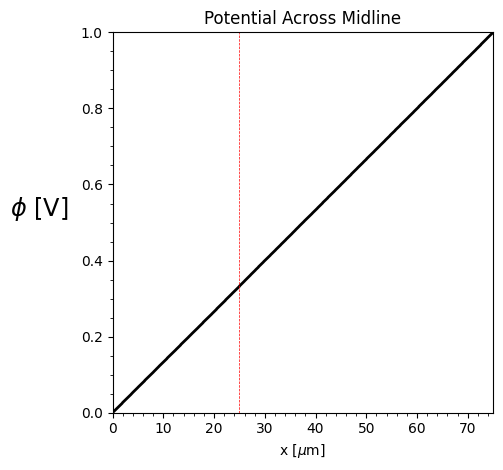

In [22]:
bb_trees = bb_tree(domain, domain.topology.dim)
n_points = 10000
tol = 1e-8  # Avoid hitting the outside of the domain
x = np.linspace(tol, 75e-6 - tol, n_points)
y = np.ones(n_points) * 0.5 * 40e-6  # midline
points = np.zeros((3, n_points))
points[0] = x
points[1] = y
u_values = []
cells = []
points_on_proc = []
# Find cells whose bounding-box collide with the the points
cell_candidates = compute_collisions_points(bb_trees, points.T)
# Choose one of the cells that contains the point
colliding_cells = compute_colliding_cells(domain, cell_candidates, points.T)
for i, point in enumerate(points.T):
    if len(colliding_cells.links(i)) > 0:
        points_on_proc.append(point)
        cells.append(colliding_cells.links(i)[0])
points_on_proc = np.array(points_on_proc, dtype=np.float64)
u_values = u_dg.eval(points_on_proc, cells)
fig, ax = plt.subplots()
ax.plot((1/1e-6) * points_on_proc[:, 0], u_values, "k", linewidth=2)
# ax.grid(True)
ax.axvline(x=25, linestyle='--', color='red', linewidth=0.5)
ax.set_xlim([0, 75])
ax.set_ylim([0, voltage])
ax.set_ylabel(r'$\phi$ [V]', rotation=0, labelpad=30, fontsize='xx-large')
ax.set_xlabel(r'x [$\mu$m]')
ax.set_title('Potential Across Midline')
ax.set_box_aspect(1);
ax.minorticks_on();
plt.tight_layout()
plt.show()